DSC-037 step 3: Assessment & Verfication 
---
DSC-037: Cable reflection systematics for EoR science

### Authors:
SHAO EoR Group and Teal Team

### Documentation on confluence:

Summary: This notebook is a first implementation of DSC-037 to compute and plot rudimentary (FFT, absolute value, then square) delay power spectra.

DSC description page: https://confluence.skatelescope.org/x/0rs6F
Chronological walkthrough: https://confluence.skatelescope.org/x/osw6F
Implementation: https://confluence.skatelescope.org/x/n8LMF
GitHub repo: https://github.com/uksrc-developers/dsc-037-eor


Ticket: TEAL-1128 https://jira.skatelescope.org/browse/TEAL-1128

**Dependencies:** `casacore-tools`, `python-casacore`, `pyuvdata`, `numpy`, `matplotlib`, `astropy`

Last updated: 2025-10-21

## Plot Delay-Time Dynamic Spectrum (Multi-Page Output)

This notebook calculates and plots the delay–time dynamic spectrum (waterfall) for a chosen baseline and polarization from a Measurement Set (MS) or UVFITS file.

It produces a **3-page PDF** containing:
1.  **Raw FFT:** `log(|FFT|)` and `Phase ∠FFT` (two subplots)
2.  **Amplitude:** `|FFT|`
3.  **Power:** `|FFT|^2`

## Data Pipeline

For each time sample:
1.  $V(t, f)$  --RAW FFT over frequency ($f$)-->  $\tilde{V}(t, \tau)$
2.  Amplitude: $\mathrm{AMP}(t, \tau) = |\tilde{V}(t, \tau)|$
3.  Power: $\mathrm{POWER}(t, \tau) = |\tilde{V}(t, \tau)|^2$
4.  Phase: $\mathrm{PHASE}(t, \tau) = \angle \tilde{V}(t, \tau)$

**Plot Axes:**
* **X-axis:** Time [s] (relative to first sample)
* **Y-axis:** Delay [µs]

## Notes

* Uses a **RAW FFT** (no taper/window function).
* Flagged channels are **zeroed** (unless `ignore_flags` is `True`).
* Supports `casacore.tables` (for MS) and `pyuvdata` (for UVFITS).
* Includes smart polarization fallback for UVFITS (e.g., maps `XX` to `nn` or `xx`).

In [ ]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
import yaml

try:
    from casacore.tables import table
    CASACORE_AVAILABLE = True
except ImportError:
    CASACORE_AVAILABLE = False
    print("WARNING: casacore.tables not found. MS loading will fail.")

try:
    from pyuvdata import UVData
    PYUVDATA_AVAILABLE = True
except ImportError:
    PYUVDATA_AVAILABLE = False
    print("WARNING: pyuvdata not found. UVFITS loading will fail.")

###  Utility Functions

In [22]:
def robust_percentiles(vals, low=5, high=95, floor=1e-12):
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return floor, floor * 10.0
    vmin = max(np.percentile(vals, low), floor)
    vmax = np.percentile(vals, high)
    if vmax <= vmin:
        vmax = vmin * 10.0
    return vmin, vmax

def to_edges(x):
    """Build bin edges for pcolormesh from centers."""
    x = np.asarray(x, float)
    if x.size < 2:
        dx = 1.0
        return np.array([x[0]-0.5*dx, x[0]+0.5*dx])
    dx = np.diff(x)
    dx = np.r_[dx[:1], dx]
    return np.r_[x - dx/2, x[-1] + dx[-1]/2]

### Measurement Set (MS) Helpers

In [23]:
CORR_MAP_NUM2STR = {5: 'RR', 6: 'RL', 7: 'LR', 8: 'LL', 9: 'XX', 10: 'XY', 11: 'YX', 12: 'YY'}

def ms_get_corr_index(ms_path: str, want_corr: str) -> int:
    if not CASACORE_AVAILABLE:
        raise ImportError("casacore.tables is required to read Measurement Sets.")
    pol = table(f"{ms_path}/POLARIZATION", readonly=True, ack=False)
    corr_types = pol.getcol('CORR_TYPE')[0]   # e.g. [9,10,11,12] for XX,XY,YX,YY
    pol.close()
    labels = [CORR_MAP_NUM2STR.get(int(x), str(x)) for x in list(corr_types)]
    want = want_corr.upper()
    if want not in labels:
        raise RuntimeError(f"Requested correlation {want} not found. Available: {labels}")
    return labels.index(want)

def ms_get_freq_axis_hz(ms_path: str, ddid: int) -> np.ndarray:
    if not CASACORE_AVAILABLE:
        raise ImportError("casacore.tables is required to read Measurement Sets.")
    dd = table(f"{ms_path}/DATA_DESCRIPTION", readonly=True, ack=False)
    spw_id = int(dd.getcell('SPECTRAL_WINDOW_ID', ddid))
    dd.close()
    spw = table(f"{ms_path}/SPECTRAL_WINDOW", readonly=True, ack=False)
    chan_freq_hz = spw.getcell('CHAN_FREQ', spw_id)  # Hz, shape [nchan]
    spw.close()
    return np.asarray(chan_freq_hz, dtype=float)

def ms_ant_to_index(ms_path: str, name_or_index) -> int:
    if not CASACORE_AVAILABLE:
        raise ImportError("casacore.tables is required to read Measurement Sets.")
    names = table(f"{ms_path}/ANTENNA", readonly=True, ack=False).getcol('NAME')
    s = str(name_or_index)
    if s.isdigit():
        idx = int(s)
        if idx < 0 or idx >= len(names):
            raise RuntimeError(f"Antenna index {idx} out of range [0,{len(names)-1}]")
        return idx
    where = np.where(names == s)[0]
    if where.size == 0:
        raise RuntimeError(f"Antenna '{name_or_index}' not found. Available: {list(names)}")
    return int(where[0])

def ms_list_baselines(ms_path: str):
    if not CASACORE_AVAILABLE:
        raise ImportError("casacore.tables is required to read Measurement Sets.")
    t = table(ms_path, readonly=True, ack=False)
    ants = table(f"{ms_path}/ANTENNA", readonly=True, ack=False).getcol('NAME')
    a1 = t.getcol('ANTENNA1'); a2 = t.getcol('ANTENNA2')
    bls = np.unique(np.vstack([a1, a2]).T, axis=0)
    print("\nAntenna indices & names:")
    for i, nm in enumerate(ants):
        print(f"  {i}: {nm}")
    print("\nBaselines (ANT1-ANT2):")
    for u, v in bls:
        print(f"  {u}-{v}  ({ants[u]} - {ants[v]})")
    print(f"\nTotal unique baselines: {len(bls)}\n")
    return bls, ants

### UVFITS Polarization Helper

In [24]:
def resolve_polarization(requested: str, available: list[str]) -> str:
    """
    Resolve requested polarization against available pol strings from UVData.get_pols().
    Works across differing conventions: XX/YY/XY/YX vs nn/ee/ne/en vs xx/yy etc.

    Returns the chosen available pol string (exact as in 'available'),
    or raises a RuntimeError if no suitable mapping exists.
    """
    req = requested.strip().lower()

    # Normalize available to lowercase for matching, but remember original
    avail_lower = [p.lower() for p in available]

    # If exact present, use it
    if req in avail_lower:
        return available[avail_lower.index(req)]

    # Equivalence classes (lowercase)
    equivalents = {
        'xx': ['xx', 'nn'],
        'yy': ['yy', 'ee'],
        'xy': ['xy', 'ne'],
        'yx': ['yx', 'en'],
        'rr': ['rr'],
        'll': ['ll'],
    }

    # Allow requesting 'nn' to find 'xx', and vice versa, etc.
    # First, find the canonical key for the requested pol.
    def find_key(pol: str):
        # direct canonical keys
        if pol in equivalents:
            return pol
        # map 'nn'->'xx', 'ee'->'yy', 'ne'->'xy', 'en'->'yx'
        alt_map = {'nn': 'xx', 'ee': 'yy', 'ne': 'xy', 'en': 'yx'}
        return alt_map.get(pol, pol)

    key = find_key(req)

    if key in equivalents:
        # Try to find any of the equivalent options in the available list
        for candidate in equivalents[key]:
            if candidate in avail_lower:
                chosen = available[avail_lower.index(candidate)]
                if candidate != req:
                    print(f"[INFO] Requested polarization '{requested}' not found, using fallback '{chosen}'")
                return chosen

    # As a last resort, try uppercase forms (some UVData versions might return uppercase)
    req_up = req.upper()
    avail_up = [p.upper() for p in available]
    if req_up in avail_up:
        return available[avail_up.index(req_up)]

    raise RuntimeError(f"Polarization {requested} not in {available} and no suitable fallback found.")

### Core Delay Transform

In [25]:
def fft_delay_complex(vis_tf: np.ndarray, df_hz: float):
    """
    vis_tf : (Nt, Nf) complex, per-time spectra (flagged channels already zeroed or kept)
    df_hz  : channel spacing (assumed uniform) in Hz

    Returns:
      tau_s : (Nf,) delay axis in seconds (fftshift-ed)
      F     : (Nt, Nf) complex FFT result, fftshift-ed along freq axis
    """
    # Raw FFT over frequency axis (no window)
    F = np.fft.fft(vis_tf, axis=1)
    F = np.fft.fftshift(F, axes=1)
    tau_s = np.fft.fftshift(np.fft.fftfreq(vis_tf.shape[1], d=df_hz))
    return tau_s, F

### Data Loaders

In [26]:
def load_ms_delay_waterfall(ms_path: str, ant1, ant2, corr: str, col: str = "DATA",
                            ddid_override: int | None = None,
                            timebin: int = 1, chanbin: int = 1,
                            ignore_flags: bool = False):
    if not CASACORE_AVAILABLE:
        raise ImportError("casacore.tables is required to read Measurement Sets.")
        
    t = table(ms_path, readonly=True, ack=False)
    ants = table(f"{ms_path}/ANTENNA", readonly=True, ack=False).getcol('NAME')

    a1 = ms_ant_to_index(ms_path, ant1)
    a2 = ms_ant_to_index(ms_path, ant2)
    lo, hi = sorted([a1, a2])

    q = t.query(f"ANTENNA1=={lo} && ANTENNA2=={hi}")
    if q.nrows() == 0:
        raise RuntimeError(f"No rows for baseline {lo}-{hi} ({ants[lo]} - {ants[hi]}). Use --list-baselines.")

    ddids = np.unique(q.getcol('DATA_DESC_ID'))
    if ddids.size == 0:
        raise RuntimeError("No DATA_DESC_IDs in selection.")
    if ddid_override is not None:
        if ddid_override not in ddids:
            raise RuntimeError(f"--ddid {ddid_override} not in {ddids}")
        ddid = int(ddid_override)
    else:
        if ddids.size > 1:
            print(f"[WARNING] Multiple DDIDs {ddids}; using first: {ddids[0]}")
        ddid = int(ddids[0])

    freqs_hz_full = ms_get_freq_axis_hz(ms_path, ddid)
    dnu = np.diff(freqs_hz_full)
    df_nom = np.median(dnu)
    if not np.allclose(dnu, df_nom, rtol=1e-3, atol=0):
        print("[WARNING] Non-uniform channel spacing detected; using median Δν for FFT.")

    corr_idx = ms_get_corr_index(ms_path, corr)
    have_flag = "FLAG" in t.colnames()

    step = 100000
    times_list = []
    F_rows = []

    total, flagged = 0, 0

    for start in range(0, q.nrows(), step):
        nr = min(step, q.nrows() - start)
        data = q.getcol(col, start, nr)[:, :, corr_idx]              # (nr, nchan)
        flags = q.getcol('FLAG', start, nr)[:, :, corr_idx] if have_flag else np.zeros_like(data, bool)
        time = q.getcol('TIME', start, nr)                            # (nr,)

        total += flags.size
        flagged += np.sum(flags)

        # Channel binning BEFORE FFT
        if chanbin > 1:
            nch2 = (data.shape[1] // chanbin) * chanbin
            data = data[:, :nch2].reshape(nr, -1, chanbin).mean(axis=2)
            flags = flags[:, :nch2].reshape(nr, -1, chanbin).any(axis=2)
            freqs_hz = freqs_hz_full[:nch2].reshape(-1, chanbin).mean(axis=1)
            df_eff = np.median(np.diff(freqs_hz))
        else:
            freqs_hz = freqs_hz_full
            df_eff = df_nom

        # Time binning BEFORE FFT
        if timebin > 1 and data.shape[0] >= timebin:
            k = (data.shape[0] // timebin) * timebin
            data = data[:k].reshape(-1, timebin, data.shape[1]).mean(axis=1)
            flags = flags[:k].reshape(-1, timebin, flags.shape[1]).any(axis=1)
            time  = time[:k].reshape(-1, timebin).mean(axis=1)

        # Flag handling: zero-out flagged channels unless ignoring flags
        vis_block = data if ignore_flags else np.where(~flags, data, 0.0 + 0.0j)

        # Complex FFT over frequency → delay
        tau_s, F_block = fft_delay_complex(vis_block, df_eff)  # (nr_block, nchan_eff)

        F_rows.append(F_block)
        times_list.append(time)

    q.close(); t.close()

    flag_pct = (flagged / total * 100) if total > 0 else 0.0
    print(f"[INFO] Flagged samples for baseline {lo}-{hi}: {flag_pct:.2f}% "
          f"({'IGNORED' if ignore_flags else 'applied as zeros'})")

    F_t_tau = np.vstack(F_rows)       # (Nt, Nτ) complex
    times_all = np.concatenate(times_list)

    # Seconds from first time
    t0 = np.nanmin(times_all)
    time_sec = times_all - t0
    delay_us = tau_s * 1e6

    blname = f"{lo}-{hi}"
    polname = corr.upper()
    return time_sec, delay_us, F_t_tau, blname, polname

In [27]:
def load_uvfits_delay_waterfall(uvfits_path: str, ant1, ant2, corr: str,
                                timebin: int = 1, chanbin: int = 1,
                                ignore_flags: bool = False):
    if not PYUVDATA_AVAILABLE:
        raise RuntimeError("pyuvdata required for UVFITS input.")
    uv = UVData(); uv.read(uvfits_path)

    # Antenna mapping
    def uv_ant_to_index(uvo, a):
        try:
            return int(a)
        except Exception:
            names = np.array(uvo.antenna_names)
            where = np.where(names == a)[0]
            if where.size == 0:
                raise RuntimeError(f"Antenna '{a}' not found in UVFITS.")
            return int(where[0])

    a1 = uv_ant_to_index(uv, ant1)
    a2 = uv_ant_to_index(uv, ant2)

    # Pol resolution with fallback
    pols_available = uv.get_pols() if hasattr(uv, "get_pols") else []
    chosen_pol_str = resolve_polarization(corr, pols_available)
    # Convert chosen string to polarization code index:
    # uv.polarization_array holds codes; get index via get_pols() matching
    pols_list = list(uv.get_pols())  # strings in same order as polarization_array
    pol_code = uv.polarization_array[pols_list.index(chosen_pol_str)]

    vis = uv.get_data((a1, a2, pol_code))    # (Nt, Nf)
    flags = uv.get_flags((a1, a2, pol_code)) # (Nt, Nf)
    freqs_hz_full = uv.freq_array[0] if uv.freq_array.ndim == 2 else uv.freq_array
    freqs_hz_full = np.asarray(freqs_hz_full, float)

    # Channel binning BEFORE FFT
    if chanbin > 1:
        nch2 = (vis.shape[1] // chanbin) * chanbin
        vis = vis[:, :nch2].reshape(vis.shape[0], -1, chanbin).mean(axis=2)
        flags = flags[:, :nch2].reshape(flags.shape[0], -1, chanbin).any(axis=2)
        freqs_hz = freqs_hz_full[:nch2].reshape(-1, chanbin).mean(axis=1)
    else:
        freqs_hz = freqs_hz_full

    # Time binning BEFORE FFT
    times_jd = uv.get_times((a1, a2, pol_code))
    if timebin > 1 and vis.shape[0] >= timebin:
        k = (vis.shape[0] // timebin) * timebin
        vis = vis[:k].reshape(-1, timebin, vis.shape[1]).mean(axis=1)
        flags = flags[:k].reshape(-1, timebin, flags.shape[1]).any(axis=1)
        times_jd = times_jd[:k].reshape(-1, timebin).mean(axis=1)

    # Flag handling
    vis_proc = vis if ignore_flags else np.where(~flags, vis, 0.0 + 0.0j)

    # Δν
    dnu = np.diff(freqs_hz)
    df_nom = np.median(dnu)
    if not np.allclose(dnu, df_nom, rtol=1e-3, atol=0):
        print("[WARNING] Non-uniform channel spacing detected; using median Δν for FFT.")

    # Complex FFT over frequency → delay
    tau_s, F_t_tau = fft_delay_complex(vis_proc, df_nom)
    delay_us = tau_s * 1e6

    # Time (seconds from first)
    time_sec = (times_jd - np.min(times_jd)) * 86400.0

    blname = f"{a1}-{a2}"
    polname = chosen_pol_str.upper()
    if polname != corr.upper():
        print(f"[INFO] Using polarization '{polname}' as fallback for requested '{corr}'")
    return time_sec, delay_us, F_t_tau, blname, polname

### Plotting Function (3-Page PDF)

This function saves a 3-page PDF and also displays the three figures inline.

In [28]:
def plot_three_page_pdf(time_sec, delay_us, F_t_tau, title_base, out_pdf,
                        vmin=None, vmax=None, log=True, show=True):
    """
    Writes a 3-page PDF and optionally displays plots inline:
      1) Raw FFT: log(|FFT|) and Phase (two subplots)
      2) |FFT|
      3) |FFT|^2

    Parameters:
        show (bool): If True, also display the three figures inline.
    """
    # Derived products
    AMP = np.abs(F_t_tau)          # (Nt, Nτ)
    POWER = AMP**2                 # (Nt, Nτ)
    PHASE = np.angle(F_t_tau)      # (Nt, Nτ), wrapped −π..π

    # Robust color ranges
    amp_vmin, amp_vmax = robust_percentiles(AMP, 5, 95, floor=1e-12)
    pow_vmin, pow_vmax = robust_percentiles(POWER, 5, 95, floor=1e-12)

    # Use user overrides if provided (for pages 2 & 3)
    if vmin is not None:
        amp_vmin = pow_vmin = max(vmin, 1e-12)
    if vmax is not None:
        amp_vmax = pow_vmax = max(vmax, amp_vmin * 1.01)

    # Mesh edges
    t_edges = to_edges(time_sec)
    d_edges = to_edges(delay_us)

    with PdfPages(out_pdf) as pdf:

        # -------- Page 1: Raw FFT -> two subplots (log|FFT| & phase)
        fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.8, 8.4), sharex=True)
        # Top: log(|FFT|)
        mesh1 = ax1.pcolormesh(
            t_edges, d_edges, AMP.T, shading="auto",
            norm=LogNorm(vmin=max(amp_vmin, 1e-12), vmax=amp_vmax),
            cmap="Spectral_r"
        )
        c1 = fig1.colorbar(mesh1, ax=ax1)
        c1.set_label("log |FFT| (arb.)")
        ax1.set_ylabel("Delay [µs]")
        ax1.set_title(f"{title_base} — Raw FFT: log(|FFT|) & Phase")

        # Bottom: Phase (−π..π), twilight colormap
        mesh2 = ax2.pcolormesh(
            t_edges, d_edges, PHASE.T, shading="auto",
            cmap="twilight", vmin=-np.pi, vmax=np.pi
        )
        c2 = fig1.colorbar(mesh2, ax=ax2)
        c2.set_label("Phase ∠FFT [rad]")
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("Delay [µs]")

        fig1.tight_layout()
        pdf.savefig(fig1)
        print("Displaying Page 1: Raw FFT (log|FFT| & Phase)")
        if show:
            display(fig1)
        plt.close(fig1)

        # -------- Page 2: |FFT|
        fig2 = plt.figure(figsize=(7.8, 5.8))
        ax = fig2.add_subplot(111)
        norm = LogNorm(vmin=max(amp_vmin, 1e-12), vmax=amp_vmax) if log else None
        mesh = ax.pcolormesh(
            t_edges, d_edges, AMP.T, shading="auto",
            norm=norm, cmap="Spectral_r"
        )
        cbar = fig2.colorbar(mesh)
        cbar.set_label("|FFT| (arb.)")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Delay [µs]")
        ax.set_title(f"{title_base} — |FFT|")
        fig2.tight_layout()
        pdf.savefig(fig2)
        print("Displaying Page 2: |FFT|")
        if show:
            display(fig2)
        plt.close(fig2)

        # -------- Page 3: |FFT|^2
        fig3 = plt.figure(figsize=(7.8, 5.8))
        ax = fig3.add_subplot(111)
        norm = LogNorm(vmin=max(pow_vmin, 1e-12), vmax=pow_vmax) if log else None
        mesh = ax.pcolormesh(
            t_edges, d_edges, POWER.T, shading="auto",
            norm=norm, cmap="Spectral_r"
        )
        cbar = fig3.colorbar(mesh)
        cbar.set_label("|FFT|² (arb.)")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Delay [µs]")
        ax.set_title(f"{title_base} — |FFT|²")
        fig3.tight_layout()
        pdf.savefig(fig3)
        print("Displaying Page 3: |FFT|^2")
        if show:
            display(fig3)
        plt.close(fig3)

    print(f"\n[INFO] Saved 3-page PDF: {out_pdf}")

### Configuration & Execution 

Common parameters (input_file, ant1, ant2, corr, col, timebin, chanbin, use_weights, chunksize, format) are loaded from `config.yaml`.
Notebook-specific parameters (ddid, list_baselines, ignore_flags, vmin, vmax, no_log, plot_title_base, out_file, show) are set in the cell below.

In [ ]:
# --- Load Common Configuration from config.yaml ---
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Common parameters from config.yaml
COMMON_INPUT_FILE = config.get('input_file', '')
COMMON_ANT1 = config.get('ant1', '2')
COMMON_ANT2 = config.get('ant2', '6')
COMMON_CORR = config.get('corr', 'XX')
COMMON_COL = config.get('col', 'DATA')
COMMON_TIMEBIN = config.get('timebin', 1)
COMMON_CHANBIN = config.get('chanbin', 1)
COMMON_USE_WEIGHTS = config.get('use_weights', False)
COMMON_CHUNKSIZE = config.get('chunksize', 100000)
COMMON_FORMAT = config.get('format', 'auto')
COMMON_OUTDIR = config.get('outdir', './')

# --- Notebook-specific parameters (set these as needed) ---
# MS directory or UVFITS file (use config.yaml value if provided, otherwise use default)
if COMMON_INPUT_FILE:
    INPUT_FILE = COMMON_INPUT_FILE
else:
    INPUT_FILE = "L253456_SAP000_002_time1.flagged.5ch8s.dical.MS"

# [MS ONLY] DATA_DESC_ID override (default: None)
DDID = None

# [MS ONLY] List baselines and exit (set to True, run, then set back to False)
LIST_BASELINES = False

# Processing parameters
IGNORE_FLAGS = False

# Plotting parameters
VMIN = None  # (Optional) color min for |FFT|/|FFT|^2 pages
VMAX = None  # (Optional) color max for |FFT|/|FFT|^2 pages
NO_LOG = False  # Disable log color for |FFT| and |FFT|^2 pages
PLOT_TITLE_BASE = "Delay–Time Waterfall"
OUT_FILE = "delay_waterfall_full.pdf"
SHOW = True  # Display plots inline

# --- Main Execution Logic ---
def execute_delay_time_waterfall(
    input_file=None,
    ant1=None,
    ant2=None,
    corr=None,
    col=None,
    ddid=None,
    list_baselines=None,
    ignore_flags=None,
    timebin=None,
    chanbin=None,
    vmin=None,
    vmax=None,
    no_log=None,
    plot_title_base=None,
    out_file=None,
    show=None
):
    """
    Executes the delay–time waterfall plotting for MS or UVFITS files.
    
    Common parameters (ant1, ant2, corr, col, timebin, chanbin, format) default to config.yaml.
    Notebook-specific parameters default to values set in the cell above.
    Parameters can be overridden by passing them as function arguments.
    """
    # Use config defaults for common parameters if not provided
    if ant1 is None:
        ant1 = COMMON_ANT1
    if ant2 is None:
        ant2 = COMMON_ANT2
    if corr is None:
        corr = COMMON_CORR
    if col is None:
        col = COMMON_COL
    if timebin is None:
        timebin = COMMON_TIMEBIN
    if chanbin is None:
        chanbin = COMMON_CHANBIN
    
    # Use notebook-specific defaults if not provided
    if input_file is None:
        input_file = INPUT_FILE
    if ddid is None:
        ddid = DDID
    if list_baselines is None:
        list_baselines = LIST_BASELINES
    if ignore_flags is None:
        ignore_flags = IGNORE_FLAGS
    if vmin is None:
        vmin = VMIN
    if vmax is None:
        vmax = VMAX
    if no_log is None:
        no_log = NO_LOG
    if plot_title_base is None:
        plot_title_base = PLOT_TITLE_BASE
    if out_file is None:
        out_file = OUT_FILE
    if show is None:
        show = SHOW
    
    # Prepend outdir to output file path
    if not os.path.isabs(out_file):
        out_file = os.path.join(COMMON_OUTDIR, out_file)
    try:
        # MS or UVFITS?
        if os.path.isdir(input_file):
            if list_baselines:
                print(f"Listing baselines for {input_file}...")
                ms_list_baselines(input_file)
            else:
                print(f"Loading MS: {input_file}")
                time_sec, delay_us, F_t_tau, bl, pol = load_ms_delay_waterfall(
                    input_file, ant1, ant2, corr,
                    col=col, ddid_override=ddid,
                    timebin=timebin, chanbin=chanbin,
                    ignore_flags=ignore_flags
                )
                
                out_pdf = out_file if out_file.endswith(".pdf") else out_file + ".pdf"
                base_title = plot_title_base if plot_title_base else f"Delay–Time Waterfall: {bl}, {pol}"

                plot_three_page_pdf(
                    time_sec, delay_us, F_t_tau, base_title, out_pdf,
                    vmin=vmin, vmax=vmax,
                    log=(not no_log)
                )

        elif os.path.isfile(input_file):
            print(f"Loading UVFITS: {input_file}")
            time_sec, delay_us, F_t_tau, bl, pol = load_uvfits_delay_waterfall(
                input_file, ant1, ant2, corr,
                timebin=timebin, chanbin=chanbin,
                ignore_flags=ignore_flags
            )
            
            out_pdf = out_file if out_file.endswith(".pdf") else out_file + ".pdf"
            base_title = plot_title_base if plot_title_base else f"Delay–Time Waterfall: {bl}, {pol}"

            plot_three_page_pdf(
                time_sec, delay_us, F_t_tau, base_title, out_pdf,
                vmin=vmin, vmax=vmax,
                log=(not no_log), 
                show=show
            )
        else:
            if not list_baselines:
                print(f"[ERROR] Input file not found or is not a directory (MS) or file (UVFITS): {input_file}")

    except (RuntimeError, ImportError, FileNotFoundError, NameError) as e:
        print(f"\n[ERROR] An error occurred: {e}")
        print("Please check your parameters, file paths, and required libraries (casacore, pyuvdata).")



## Plot for LOFAR Data

Loading MS: L253456_SAP000_002_time1.flagged.5ch8s.dical.MS
[WARNING] Non-uniform channel spacing detected; using median Δν for FFT.
[INFO] Flagged samples for baseline 2-6: 0.02% (applied as zeros)
Displaying Page 1: Raw FFT (log|FFT| & Phase)


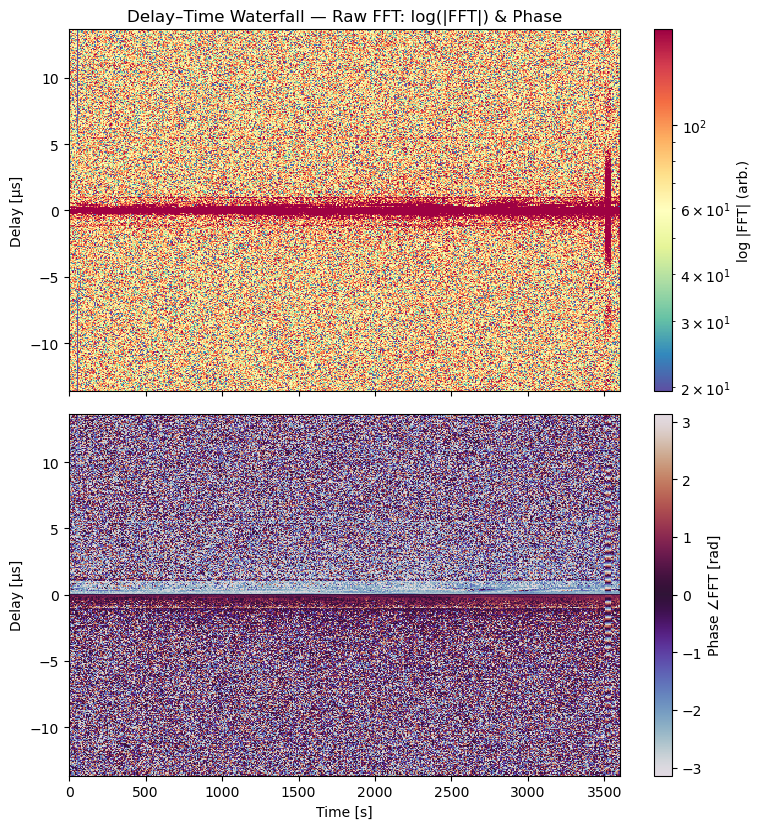

Displaying Page 2: |FFT|


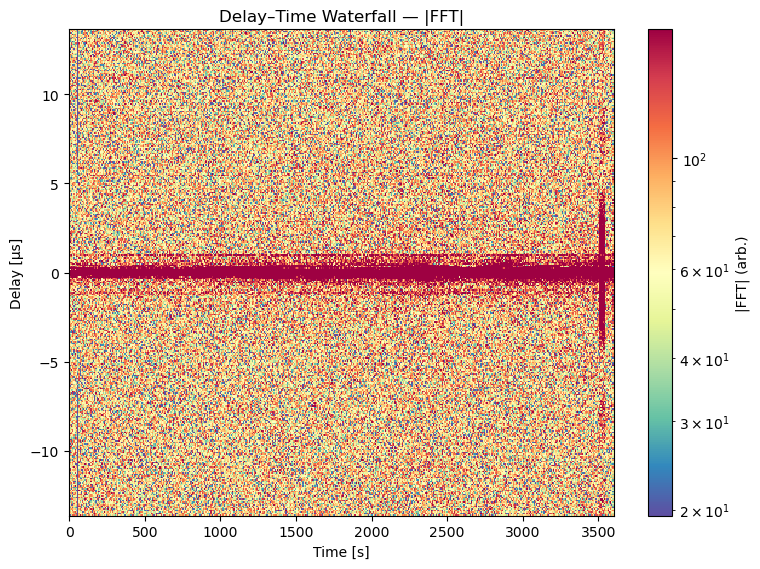

Displaying Page 3: |FFT|^2


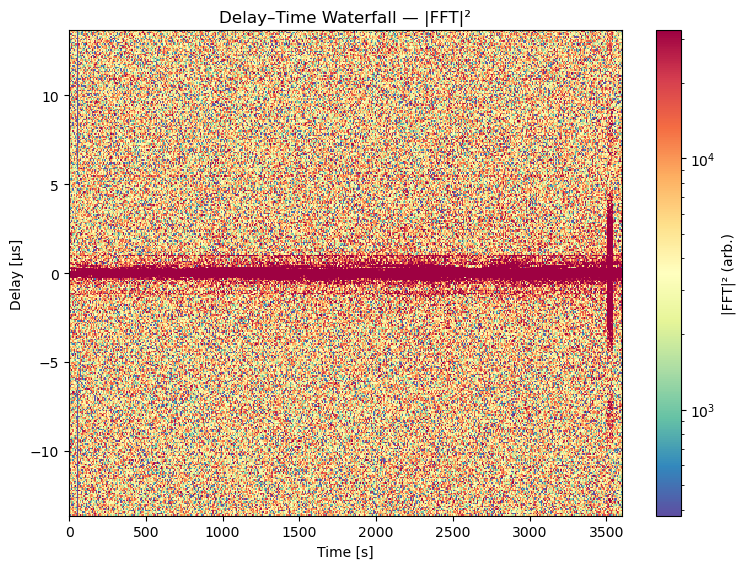


[INFO] Saved 3-page PDF: delay_waterfall_full.pdf


In [ ]:
# --- Execute using config.yaml and notebook parameters ---
# Common parameters from config.yaml: input_file, ant1, ant2, corr, col, timebin, chanbin, format
# INPUT_FILE is set above (from config.yaml if provided, otherwise default)
# Notebook-specific parameters: DDID, LIST_BASELINES, IGNORE_FLAGS, VMIN, VMAX, NO_LOG, PLOT_TITLE_BASE, OUT_FILE, SHOW
# To customize, edit config.yaml for common params, or modify variables above for notebook-specific params

execute_delay_time_waterfall()



## Plot for MWA data

Loading UVFITS: hyp_1184702048_ionosub_ssins_30l_src8k_300it_8s_80kHz_i1000.uvfits
[INFO] Requested polarization 'XX' not found, using fallback 'nn'
[INFO] Using polarization 'NN' as fallback for requested 'XX'
Displaying Page 1: Raw FFT (log|FFT| & Phase)


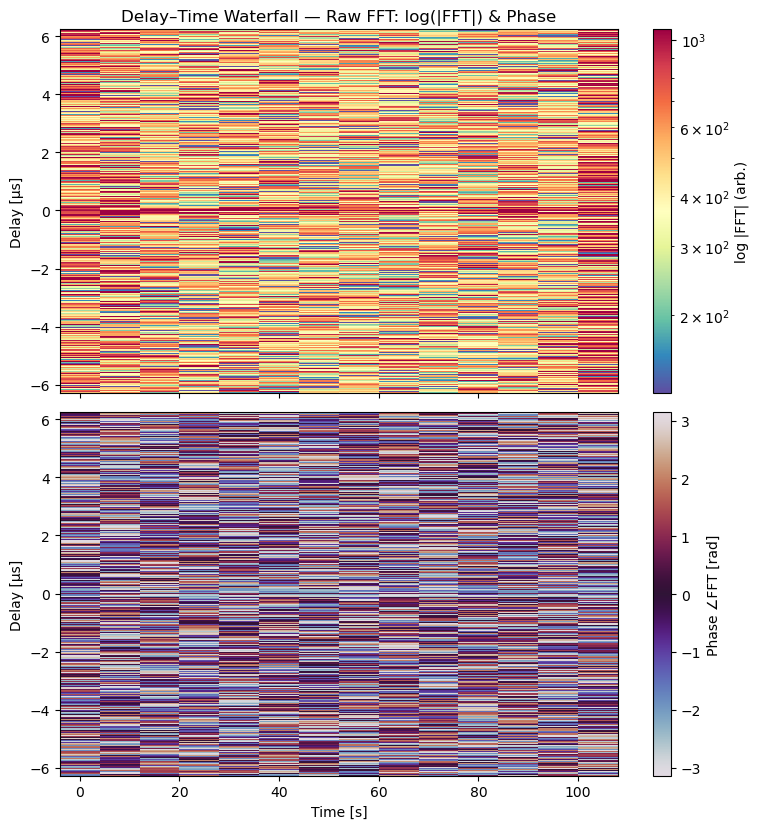

Displaying Page 2: |FFT|


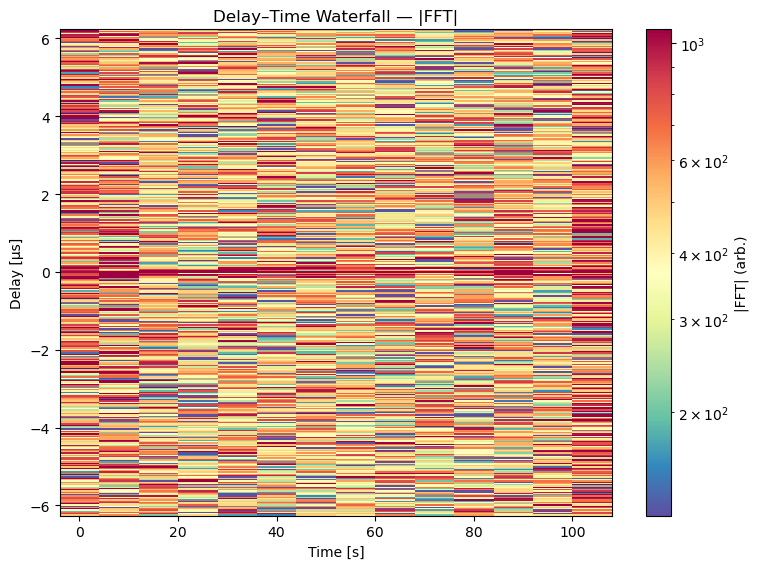

Displaying Page 3: |FFT|^2


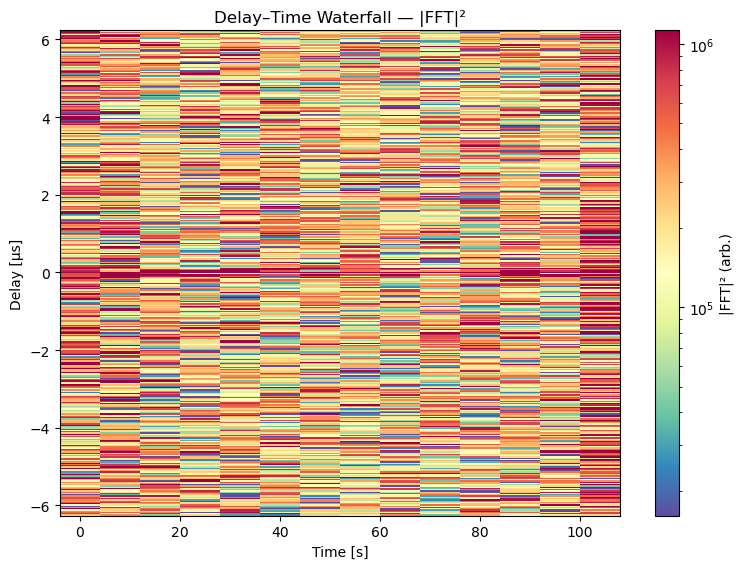


[INFO] Saved 3-page PDF: delay_waterfall_full.pdf


In [ ]:
# --- Execute with MWA-specific config ---
# Override notebook-specific parameters for this execution:

execute_delay_time_waterfall(
    input_file="hyp_1184702048_ionosub_ssins_30l_src8k_300it_8s_80kHz_i1000.uvfits"
    # Common parameters (ant1, ant2, corr, etc.) come from config.yaml
    # Can override here if needed, e.g.:
    # , corr="XX"
    # , ant1="2"
    # , ant2="6"
)

